In [1]:
import os
import random
import time
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [2]:
data_dir = Path.cwd() / 'data'
result_dir = Path.cwd() / 'results'
fig_dir = Path.cwd() / 'figures'
adata_name = 'SAGE-20201013.h5ad'
model = 'SAGE'

In [3]:
df = {}
for name in ['4.5_1', '4.5_2', '4.5_3', '6.5_1', '6.5_2', '9.5_1', '9.5_2', '9.5_3']:
    df[name] = pd.read_csv(data_dir / 'spots_PCW{}.csv'.format(name))
    df[name]['pcw'] = int(name[0])
    df[name]['section'] = int(name[-1])
    df[name] = df[name].set_index('{}_'.format(name) + df[name].index.astype(str))
df_heart = pd.concat(df.values())
df_nodes = pd.read_csv(result_dir / 'nodes.csv', index_col=0)
df_heart = df_heart.loc[df_nodes.index]

In [4]:
df_taglist = pd.read_csv(data_dir / 'taglist_heart.csv', names=['tag', 'gene'])
gene_tag_dict = pd.Series(df_taglist['tag'].to_list(), index=df_taglist['gene']).to_dict()
df_heart['barcode'] = df_heart['gene'].map(gene_tag_dict)
df_heart

,gene,spotX,spotY,pcw,section,barcode
4.5_1_11,MYRF,3242.580,1736.800,4,1,TTTCC
4.5_1_18,ITLN1,3217.077,1764.718,4,1,TCGGC
4.5_1_14,CPE,3260.000,1745.267,4,1,CTGAT
4.5_1_15,CRABP2,3269.818,1748.345,4,1,GACTT
4.5_1_12,TNNI1,3098.909,1738.303,4,1,GTGCC
...,...,...,...,...,...,...
9.5_3_538710,MYH7,18068.310,24232.630,9,3,TCAGT
9.5_3_538718,MYOM1,18049.890,24246.370,9,3,GTATC
9.5_3_538694,MYL2,18028.650,24213.420,9,3,ATGCT
9.5_3_538712,COL1A1,18189.620,24235.260,9,3,ACACA


In [5]:
adata = sc.read(result_dir / adata_name)
df_heart['louvain'] = adata.obs['louvain'].astype('int64')
print(df_heart['louvain'].value_counts())

0     144460
1     144310
2     139176
3     138502
4     135835
5     132296
6     132136
7     122098
8     118574
9     116830
10    111536
11    108456
12     94371
13     91204
14     79697
15     79000
16     75618
17     74643
18     74638
19     65563
20     49979
21     48863
22     48746
23     40121
24     31678
25     16041
26      2963
27       355
28        47
Name: louvain, dtype: int64


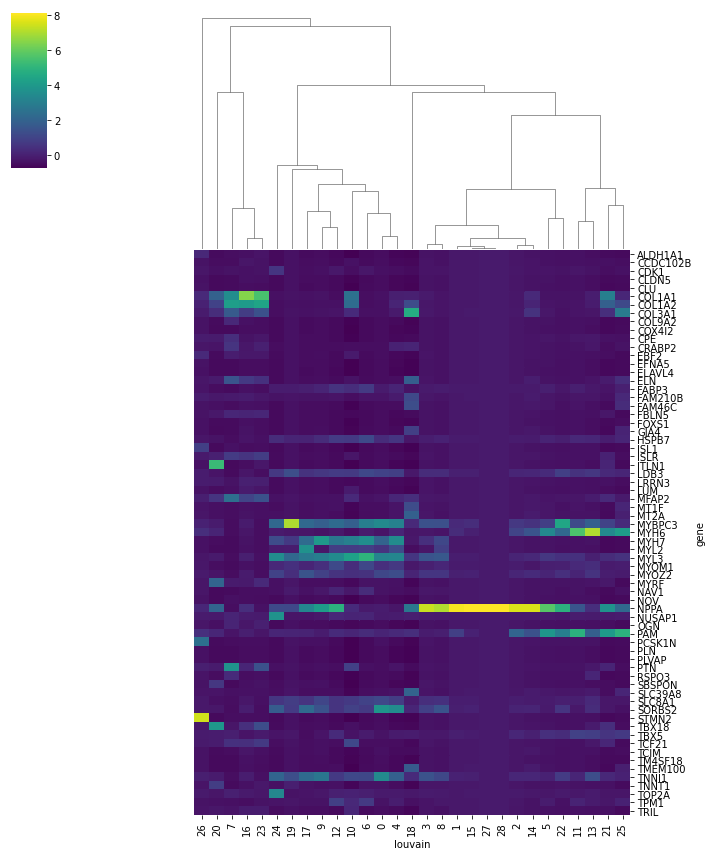

In [6]:
table1 = pd.crosstab(df_heart['gene'], df_heart['louvain'])
table1 = pd.DataFrame(data=StandardScaler().fit_transform(table1.to_numpy()), index=table1.index, columns=table1.columns)
g = sns.clustermap(
    table1, method='average', metric='correlation', figsize=(10, 12), row_cluster=False, dendrogram_ratio=0.3, 
    cmap='viridis', xticklabels=True, yticklabels=True)
g.savefig(fig_dir / 'hm_pre.png')

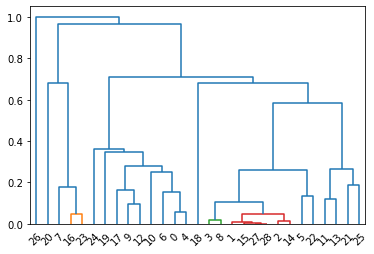

In [7]:
cutoff = 0.05
Z = linkage(table1.to_numpy().T, method='average', metric='correlation')
merged_labels = dict(zip(table1.columns, fcluster(Z, cutoff, criterion='distance')))
df_heart['cluster_merged'] = df_heart['louvain'].map(merged_labels)
fig, ax = plt.subplots()
dn = dendrogram(Z, color_threshold=cutoff)
fig.savefig(fig_dir / 'dg.png')

In [8]:
cluster_size = df_heart['cluster_merged'].value_counts()
cluster_kept = cluster_size[cluster_size > 100].index
df_heart = df_heart[df_heart['cluster_merged'].isin(cluster_kept)]
print(df_heart.shape)

(2417736, 8)


In [9]:
_, indices = np.unique(df_heart['cluster_merged'], return_inverse=True)
df_heart['spage2vec'] = indices

In [10]:
adata.obs['spage2vec'] = df_heart['spage2vec']
adata.obs['spage2vec'] = adata.obs['spage2vec'].fillna(value=-1)
adata.obs['spage2vec'] = adata.obs['spage2vec'].astype('int64')
adata.write(result_dir / adata_name)

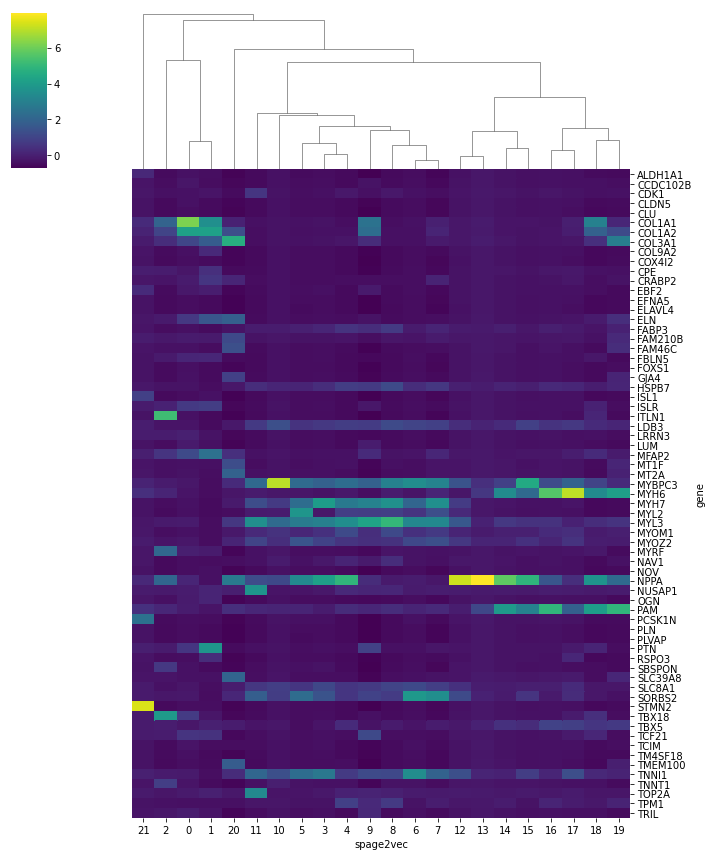

In [11]:
table2 = pd.crosstab(df_heart['gene'], df_heart['spage2vec'])
table2 = pd.DataFrame(data=StandardScaler().fit_transform(table2.to_numpy()), index=table2.index, columns=table2.columns)
g = sns.clustermap(
    table2, method='average', metric='correlation', figsize=(10, 12), row_cluster=False,
    cmap='viridis', xticklabels=True, yticklabels=True)
g.savefig(fig_dir / 'hm.png')

In [12]:
df_celltype = pd.read_csv(result_dir / 'celltype.csv', index_col=0)
df_heart_ct = pd.concat([df_heart, df_celltype], axis=1, join='inner')
df_heart_ct = df_heart_ct[df_heart_ct['cell_type_id'] >= 0]

In [13]:
df_heart['cell_type_id'] = df_celltype
df_heart['cell_type_id'] = df_heart['cell_type_id'].astype('Int64')

(22, 12)


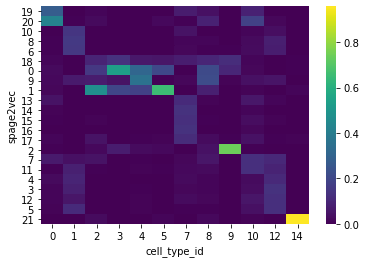

In [14]:
table3 = pd.crosstab(df_heart_ct['spage2vec'], df_heart_ct['cell_type_id'])
table3 = table3.divide(table3.sum(axis=1), axis=0)
table3 = table3.divide(table3.sum(axis=0), axis=1)
row_order = table3.idxmax(axis=1).sort_values().index
g = sns.heatmap(table3.reindex(row_order), cmap='viridis', xticklabels=True, yticklabels=True)
print(table3.shape)
g.figure.savefig(fig_dir / 'cm.png', dpi=100)

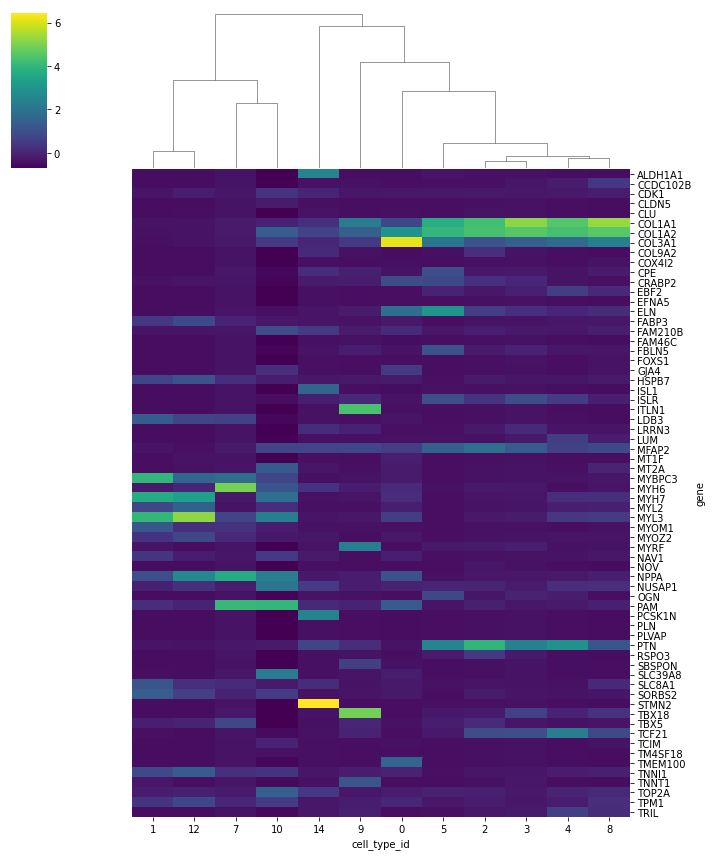

In [15]:
table4 = pd.crosstab(df_heart_ct['gene'], df_heart_ct['cell_type_id'])
table4 = pd.DataFrame(data=StandardScaler().fit_transform(table4.to_numpy()), index=table4.index, columns=table4.columns)
g = sns.clustermap(
    table4, method='average', metric='correlation', figsize=(10, 12), row_cluster=False,
    cmap='viridis', xticklabels=True, yticklabels=True)
g.savefig(fig_dir / 'hm_ct.png')

In [16]:
height = np.array([13500, 19500, 26000])
width = 24000
name_list = ['4.5_1', '4.5_2', '4.5_3', '6.5_1', '6.5_2', '', '9.5_1', '9.5_2', '9.5_3']
df_heart_csv = df_heart.copy()
for i, pcw in zip(range(3), [4, 6, 9]):
    for j, section in zip(range(3), [1, 2, 3]):
        if pcw == 6 and section == 3:
            continue
        criterion = (df_heart['pcw']==pcw) & (df_heart['section']==section)
        df_heart_csv.loc[criterion, 'spotX'] = df_heart.loc[criterion, 'spotX'] + j*width
        df_heart_csv.loc[criterion, 'spotY'] = df_heart.loc[criterion, 'spotY'] + height[:i].sum()
df_heart_csv.to_csv(result_dir / 'spage2vec_22.csv')